We'll be working with a modified version of a database called [Chinook](https://github.com/lerocha/chinook-database). The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Here's a schema diagram for the Chinook database:

![title](chinook-schema.png)

In [20]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

## Creating Helper Functions

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [3]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(q)

In [4]:
def show_tables():
    q='''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Figuring out which albums to purchase

In [6]:
albums_to_purchase='''
WITH tracks_usa AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )
   
SELECT 
    g.name genre,
    COUNT(tu.invoice_line_id) total_tracks,
    cast(COUNT(tu.invoice_line_id) as float) / 
        (SELECT COUNT(*) from tracks_usa) percent_sold
FROM tracks_usa tu
INNER JOIN track t ON tu.track_id=t.track_id
INNER JOIN genre g ON t.genre_id=g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

'''

In [7]:
genre_sales_usa = run_query(albums_to_purchase)

In [8]:
genre_sales_usa

,genre,total_tracks,percent_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [9]:
genre_sales_usa.set_index("genre",drop=True, inplace=True)

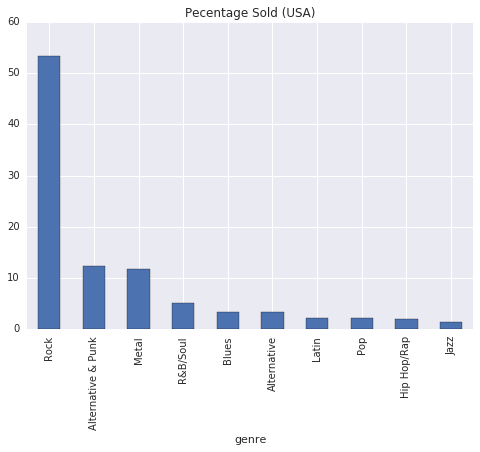

In [10]:
genre_sales_usa["percent_sold"]= genre_sales_usa["percent_sold"]*100
genre_sales_usa["percent_sold"].plot.bar()
plt.title("Pecentage Sold (USA)")
plt.show()


** Comments: **
- It can be seen that the top 3 selling genres inlcude Rock, Alternative & Punk, and Metal.
- The genres from the new record label are- Hip-Hop, Punk, Pop and Blues.
- Based on the sales of tracks from various genres, it would be beneficial for the store to buy the tracks belonging to genres- Punk, Pop and Blues.
- So, Red Tone, Meteor and the Girls, and Slim Jim Bites should be selected.
- An interesting fact to think about is that these 3 genres are not the most popular ones. Here, we suggest to choose them because they are relatively more profitable but the store should buy Rock records often for max profit.

## Evaluating Employee Performance

In [11]:
sales_per_employee='''
with employee_info AS
(
    SELECT 
        c.support_rep_id,
        i.customer_id,
        SUM(i.total) total
    FROM customer c 
    INNER JOIN invoice i ON c.customer_id= i.customer_id
    GROUP BY 1,2
)

SELECT 
    e.first_name || " " || e.last_name employee_name,
    sum(ei.total) sales_for_this_employee,
    e.hire_date
FROM employee_info ei
INNER JOIN employee e ON e.employee_id= ei.support_rep_id
GROUP BY 1;


'''

In [12]:
run_query(sales_per_employee)

,employee_name,sales_for_this_employee,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


** Comments:**
- From the table above it can be observed that Jane has the most sales, which makes sense also because of the fact that she has been at the store the longest.
- Similar is the case with Margaret.
- But, with Steve, he joined the latest but was responsible for comparable sales sooner than the others. 
- Steve is really good at this! 
- The folowing shows the above.

In [13]:
spe= run_query(sales_per_employee)

In [14]:
spe.set_index("employee_name",drop=True, inplace=True)

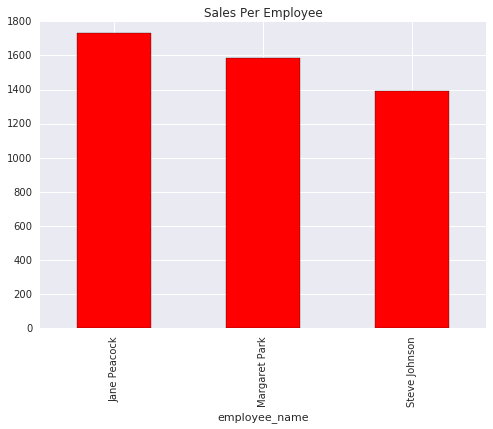

In [15]:
spe["sales_for_this_employee"].plot.bar( color='red')
plt.title("Sales Per Employee")
plt.show()


## Evaluating purchases country-wise

In [16]:
country_eval= '''
WITH other_case AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )


SELECT 
    country,
    customers,
    total_sales,
    avg_sale_per_customer,
    avg_order_value
FROM
    (
        SELECT 
            country,
            count(customer_id) customers,
            sum(unit_price) total_sales,
            sum(unit_price)/ count(distinct customer_id) avg_sale_per_customer,
            sum(unit_price)/ count(distinct invoice_id) avg_order_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort_order
        FROM other_case
        GROUP by 1
        order by sort_order ASC, total_sales DESC
    );
'''

In [17]:
ce= run_query(country_eval)

In [18]:
ce

,country,customers,total_sales,avg_sale_per_customer,avg_order_value
0,USA,1051,1040.49,80.037692,7.942672
1,Canada,541,535.59,66.948750,7.047237
2,Brazil,432,427.68,85.536000,7.011148
3,France,393,389.07,77.814000,7.781400
4,Germany,338,334.62,83.655000,8.161463
5,Czech Republic,276,273.24,136.620000,9.108000
6,United Kingdom,248,245.52,81.840000,8.768571
7,Portugal,187,185.13,92.565000,6.383793
8,India,185,183.15,91.575000,8.721429
9,Other,1106,1094.94,72.996000,7.448571


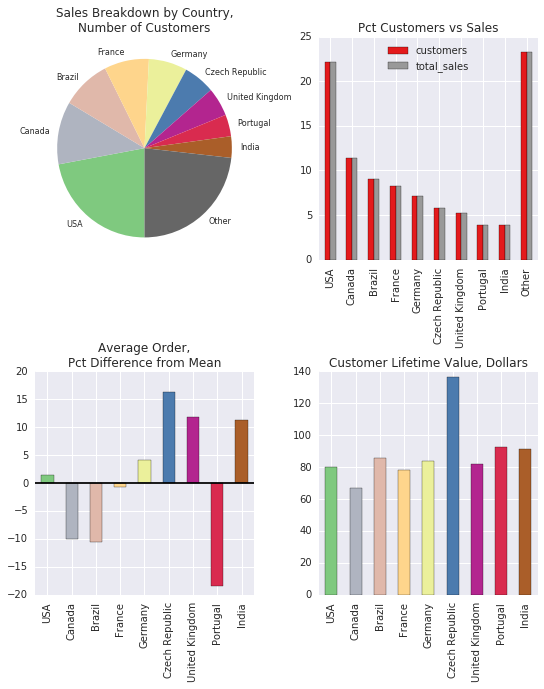

In [24]:
ce = run_query(country_eval)
ce.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, ce.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = ce["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = ce[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = ce["avg_order_value"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = ce["avg_sale_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India


It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Evaluating the new purchasing strategy - Albums Vs. Individual Tracks

- The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.
 
- Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

- We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [25]:
new_strategy= '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''


In [26]:
ns= run_query(new_strategy)

In [27]:
ns

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Going with the proposed new strategy might not be the best idea as it can cause loss

## Future Scope:
- Which artist is used in the most playlists?
- How many tracks have been purchased vs not purchased?
- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on - popularity?